In [77]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

In [78]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [79]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [80]:
def build_dataset(words, block_size=3):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = jnp.array(X)
    Y = jnp.array(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

In [81]:
key = jax.random.PRNGKey(420+69)
# Split the data train/val/test at the word level
import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
block_size = 8
Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

(182345, 8) int32 (182345,) int32
(22933, 8) int32 (22933,) int32
(22868, 8) int32 (22868,) int32


In [82]:
import modules as nn
import importlib
importlib.reload(nn)

<module 'modules' from '/Users/ryanbarouki/Documents/Coding/makemore_jax/modules.py'>

In [83]:
emb_dim = 10
context_size = block_size
hidden_size = 68
vocab_size = 27

init_fun, forward = nn.sequential([nn.Embedding(emb_dim=emb_dim, vocab_size=vocab_size),

                                   nn.FlattenConsecutive(2),
                                   nn.Linear(fan_out=hidden_size, bias=False),
                                   nn.BatchNorm(),
                                   nn.Tanh(),

                                   nn.FlattenConsecutive(2),
                                   nn.Linear(fan_out=hidden_size, bias=False),
                                   nn.BatchNorm(),
                                   nn.Tanh(),

                                   nn.FlattenConsecutive(2),
                                   nn.Linear(fan_out=hidden_size, bias=False),
                                   nn.BatchNorm(),
                                   nn.Tanh(),

                                   nn.Linear(fan_out=vocab_size)])

key = jax.random.PRNGKey(12121)
params_and_state = init_fun(key, jnp.ones(context_size, dtype=int))


In [84]:
print(f"Number of parameters: {sum([p.size for layer in params_and_state[0].values() for p in layer])}")
for name, ps in params_and_state[0].items():
    for p in ps:
        print(f"{name}: {p.shape}")


Number of parameters: 22941
Embedding_0: (27, 10)
Linear_2: (20, 68)
BatchNorm_3: (1, 4, 68)
BatchNorm_3: (1, 4, 68)
Linear_6: (136, 68)
BatchNorm_7: (1, 2, 68)
BatchNorm_7: (1, 2, 68)
Linear_10: (136, 68)
BatchNorm_11: (1, 68)
BatchNorm_11: (1, 68)
Linear_13: (68, 27)
Linear_13: (27,)


In [ ]:
def loss_fn(params, batch_stats, X, Y):
    logits, batch_stats = forward((params, batch_stats), X)
    return optax.losses.softmax_cross_entropy_with_integer_labels(logits, Y).mean(), batch_stats

@jax.jit
def train_step(params, batch_stats, X_batch, Y_batch, lr):
    (loss, batch_stats), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch_stats, X_batch, Y_batch)

    params = jax.tree.map(lambda p, g: p - lr * g, params, grads)
    return loss, params, batch_stats

In [86]:
lossi = []
stepi = []

In [76]:
# USED TO DETERMINE GOOD LEARNING RATE
# lri = []
# lre = jnp.linspace(-3,0,1000)
#lr = 10**lre
# =====================================

# Training loop
batch_size = 32

params, batch_stats = params_and_state
for i in tqdm(range(200000)):
    lr = 0.1 if i < 100000 else 0.01
    # mini-batch
    key, subkey = jax.random.split(key)
    ix = jax.random.randint(subkey, (batch_size), 0, Xtr.shape[0])

    loss, params, batch_stats = train_step(params, batch_stats, Xtr[ix], Ytr[ix], lr)

    # Track stats to determine good learning rate
    # lri.append(lr[i])
    lossi.append(jnp.log10(loss))
    stepi.append(i)

    if i % 10000 == 0:
        print(loss)

print(loss)

  0%|          | 1/200000 [00:00<15:06:20,  3.68it/s]

[(1, 68), (1, 68), (1, 4, 68), (1, 4, 68), (1, 2, 68), (1, 2, 68)]
3.4161382


  5%|▌         | 10405/200000 [00:04<01:19, 2396.68it/s]

2.409605


 10%|█         | 20413/200000 [00:08<01:13, 2436.38it/s]

2.1776628


 15%|█▌        | 30274/200000 [00:12<01:09, 2457.45it/s]

2.348562


 20%|██        | 40391/200000 [00:17<01:06, 2392.76it/s]

1.9653268


 25%|██▌       | 50395/200000 [00:21<01:06, 2257.55it/s]

2.095037


 26%|██▋       | 52508/200000 [00:22<01:03, 2331.61it/s]


KeyboardInterrupt: 

In [87]:

def body_fun(carry, i):
    params, batch_stats, key = carry

    # deterministic schedule
    lr = jnp.where(i < 100_000, 0.1, 0.01)

    key, subkey = jax.random.split(key)
    ix = jax.random.randint(subkey, (batch_size,), 0, Xtr.shape[0])

    loss, params, batch_stats = train_step(params, batch_stats,
                                           Xtr[ix], Ytr[ix], lr)
    return (params, batch_stats, key), loss

@jax.jit
def train_all(params, batch_stats, key):
    # scan over integers [0..199999], collect losses
    (params, batch_stats, _), losses = jax.lax.scan(
        body_fun,
        (params, batch_stats, key),
        jnp.arange(epochs),
    )
    return params, batch_stats, losses

batch_size = 32
epochs = 200_000
params, batch_stats = params_and_state
params, batch_stats, losses = train_all(params, batch_stats, key)


[(1, 68), (1, 68), (1, 4, 68), (1, 4, 68), (1, 2, 68), (1, 2, 68)]


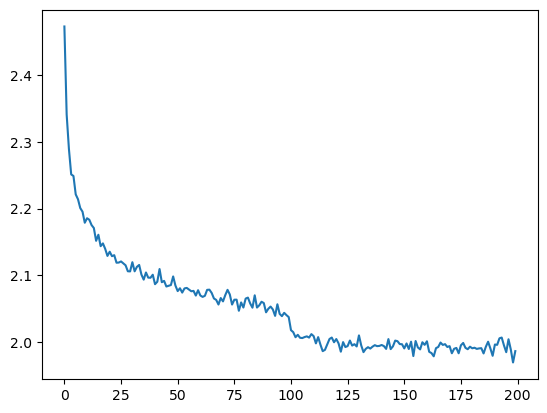

In [88]:
plt.plot(losses.reshape((-1,1000)).mean(axis=1))

In [89]:
#plt.plot(lri, lossi)
loss, _= loss_fn(params, batch_stats, Xdev, Ydev)
print(loss)

[(1, 68), (1, 68), (1, 4, 68), (1, 4, 68), (1, 2, 68), (1, 2, 68)]
2.0150037


In [90]:
# making sure you can apply the model to one example
logits, _= forward((params, batch_stats), Xdev[:1], train=False)
logits

Array([[-4.6320324 ,  1.9496434 ,  0.7657905 ,  0.8005317 ,  1.0502467 ,
         0.89655936, -0.33836663,  0.02667183,  0.39294901,  0.00603819,
         1.5542786 ,  1.4744879 ,  1.1325284 ,  1.40937   ,  0.5699303 ,
        -0.4242711 , -0.06028605, -2.0459056 ,  1.0019922 ,  1.0669174 ,
         0.6783103 , -2.3643076 , -0.4787999 , -0.5078327 , -1.3354304 ,
        -0.09397638,  0.645069  ]], dtype=float32)

In [91]:
# Sample from the trained model

sample_key = jax.random.PRNGKey(4206969)

for _ in range(20):
    out = []
    context = [0] * context_size

    sample_key, sample_sub_key = jax.random.split(sample_key)
    while True:
        sample_key, sample_sub_key = jax.random.split(sample_sub_key)
        logits, _ = forward((params, batch_stats), jnp.array([context]), train=False)
        ix = jax.random.categorical(sample_sub_key, logits)[0]
        context = context[1:] + [ix]
        out.append(int(ix))
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


nazielyn.
carvydy.
drekkel.
javeryn.
xoral.
oyusuth.
rhol.
lossa.
dalune.
sannixee.
reiha.
kayela.
avrey.
sirus.
jaleiah.
madorian.
tyreel.
johar.
tayvon.
kaden.
